# Final Project - SMS Spam Filtering
### 600.475 - Introduction to Machine Learning
### Nitin Kumar, Avi Mahajan, Archan Patel, Navjoth Thakur, Ayush Singh

We aim to create a simple binary spam classifier based on the UCI SMS Spam Collection Dataset. 

    https://www.kaggle.com/uciml/sms-spam-collection-dataset

Messages in the dataset are classifed as either "ham" for regular legitimate messages or spam. 

**Abstract:**

Our project will deal with the issue of spam messages. Spam text messages have become very common, so our purpose is to filter them out for the benefit of the user. Our implementation will use classification to determine whether or not a given message is “spam” or “not spam”. We will try using classification through regression, SVM, (TBD on neural networks). We will show how these algorithms are used in context of NLP and spam message filtering, discuss what parameters exist and how to optimize them, and then at the end compare the optimized models’ prediction accuracies and show which model is best. Using our knowledge from class, we will discuss our observations and why they make sense (or why they don’t).

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

## Data Input

First we read the data from the data/spam.csv as retrieve from Kaggle.
We then partition the data into training, validation, and testing sets. Much of the input and conversion to bag of words was taken from:

    http://radimrehurek.com/data_science_python/

In [3]:
#read in csv, and take relevant columns
messages = pd.read_csv('./data/spam.csv',skiprows=1, names=["class", "text", "r1", "r2", 'r3'], encoding='latin-1')
del messages['r1']
del messages['r2']
del messages['r3']

#Add a length column
messages['length'] = messages['text'].map(lambda text: len(text))
messages.head()

,class,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


**After reading in from the csv, we shall do some basic analyses to visualize the data.**

Mean of ham length: 71.023626943
Mean of spam length: 138.866131191
# Summary statistics for word count of all messages
mean-all 80.12 
std-all 59.69 
min-all 2.00 
max-all 910.00
# Summary statistics for word count of ham vs spam messages
mean-ham  71.02   mean-spam 138.87 
std-ham   58.02   std-spam   29.18 
min-ham    2.00   min-ham    13.00 
max-ham  910.00   max-spam  224.00


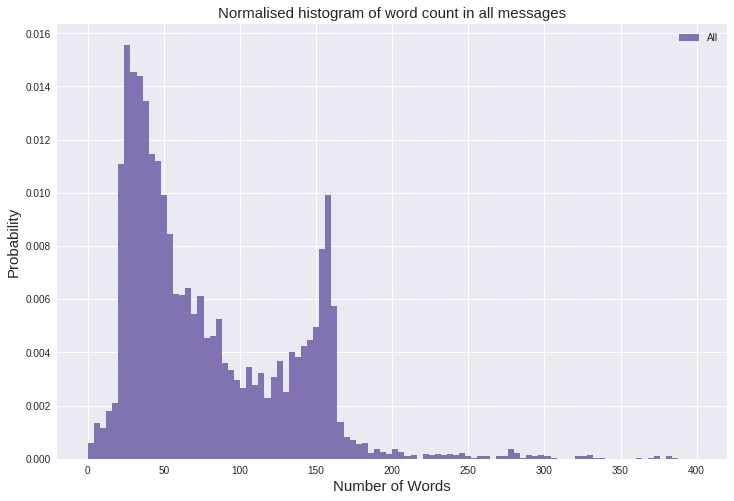

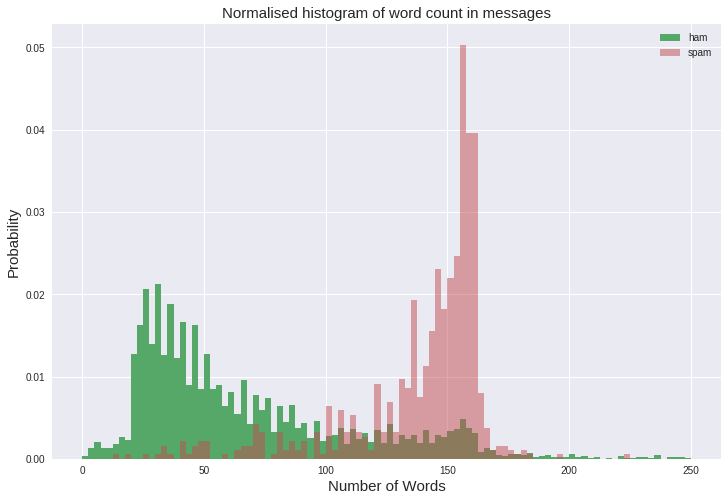

In [10]:
import seaborn as sns

print("Mean of ham length: "+str(np.mean(messages[messages['class']=='ham']['length'])))
print("Mean of spam length: "+str(np.mean(messages[messages['class']=='spam']['length'])))


pal = sns.color_palette()

# Read in data
df = pd.read_csv('./data/spam.csv', encoding='latin-1')
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df = df.rename(columns={"v1":"label", "v2":"sms_text"})

# Character count
msgs = pd.Series(df['sms_text'].tolist())
ham_messages = pd.Series(df[df['label'] == 'ham']['sms_text'].tolist())
spam_messages = pd.Series(df[df['label'] == 'spam']['sms_text'].tolist())

# Create the corresponding distribution of character counts for each list.
# We count the number of characters in each message using the `len` function.
dist_all = msgs.apply(len)
dist_ham = ham_messages.apply(len)
dist_spam = spam_messages.apply(len)

# Plot distribution of character count of all messages
plt.figure(figsize=(12, 8))
plt.hist(dist_all, bins=100, range=[0,400], color=pal[3], normed=True, label='All')
plt.title('Normalised histogram of word count in all messages', fontsize=15)
plt.legend()
plt.xlabel('Number of Words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('# Summary statistics for word count of all messages')
print('mean-all {:.2f} \nstd-all {:.2f} \nmin-all {:.2f} \nmax-all {:.2f}'.format(dist_all.mean(), 
                          dist_all.std(), dist_all.min(), dist_all.max()))

# Plot distributions of character counts for spam vs ham messages

plt.figure(figsize=(12,8))
plt.hist(dist_ham, bins=100, range=[0,250], color=pal[1], normed=True, label='ham')
plt.hist(dist_spam, bins=100, range=[0, 250], color=pal[2], normed=True, alpha=0.5, label='spam')
plt.title('Normalised histogram of word count in messages', fontsize=15)
plt.legend()
plt.xlabel('Number of Words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('# Summary statistics for word count of ham vs spam messages')
print('mean-ham  {:.2f}   mean-spam {:.2f} \nstd-ham   {:.2f}   std-spam   {:.2f} \nmin-ham    {:.2f}   min-ham    {:.2f} \nmax-ham  {:.2f}   max-spam  {:.2f}'.format(dist_ham.mean(), 
                         dist_spam.mean(), dist_ham.std(), dist_spam.std(), dist_ham.min(), dist_spam.min(), dist_ham.max(), dist_spam.max()))

In [8]:
X_train,X_test,y_train,y_test = train_test_split(messages["text"],messages["class"], test_size = 0.1, random_state = 10)

vect = CountVectorizer(analyzer='word', ngram_range=(1, 3),stop_words='english') #uses 1 - 3 word length grams
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)
prediction = dict()


**It's hard to further visualize the words, especially because we're planning to use the bag of words model, which will give us multiple very large vectors. Thus, we will begin analysis. First, we will define 2 methods that will help us understand our algorithms and data.**

In [5]:
def hyperparameter_qual(model, model_plot, param, param_plot, params, scale):
    
    test_sizes = test_sizes = np.linspace(.1,.9,9)
    # init grabbing accs
    acc_param = []
    # get vectorizer
    vect = CountVectorizer(analyzer='word', stop_words='english')

    max_acc = 0
    max_test_size = 0
    max_param = 0
    for j in test_sizes:
        # get datasets
        X_train,X_test,y_train,y_test = train_test_split(
            messages["text"],messages["class"], test_size = j, random_state = 10)
        # vectorize
        vect.fit(X_train)
        X_train_df = vect.transform(X_train)
        X_test_df = vect.transform(X_test)
        loc_y = []
        for i in params:
            model = model.set_params(**{param: i})
            model.fit(X_train_df, y_train)
            prediction = model.predict(X_test_df)
            acc = accuracy_score(y_test, prediction)
            if max_acc < acc:
                max_acc = acc
                max_test_size = j
                max_param = i
            loc_y.append(acc)
        acc_param.append(loc_y)
        
    # Plotting code
    plt.title(model_plot + ' Accuracy Score vs ' + param_plot)
    plt.ylabel('Accuracy Score')
    plt.xlabel(param_plot)
    plt.xscale(scale)
    for i in range(len(acc_param)):
        plt.plot(params, acc_param[i])
    tests = [int(len(messages['class']) * size) for size in test_sizes]
    plt.legend(test_sizes, title='Test Set Proportion')
    plt.show()
    
    print('Max Accuracy:', max_acc)
    print('Max Test Proportion:', max_test_size)
    print('Max', param_plot + ':', max_param)

In [6]:
def create_confuse(model_name, confuse, extra_title):
    confuse = confuse.astype('float') / confuse.sum(axis=1)[:, np.newaxis]
    plt.imshow(confuse, cmap=plt.cm.Blues, interpolation='nearest')
    plt.title(model_name + ' Normalized Confusion Matrix ' + extra_title)
    plt.colorbar()
    plt.grid('off')
    plt.ylabel('Expected Label')
    plt.xlabel('Predicted Label')
    tick_marks = ['ham', 'spam']
    plt.xticks([0, 1], tick_marks)
    plt.yticks([0, 1], tick_marks)
    plt.show()

def plot_confuse(model, X_train_df, y_train, X_test_df, y_test, model_name, extra_title):
    model.fit(X_train_df, y_train)
    prediction = model.predict(X_test_df)
    
    confuse = confusion_matrix(y_test, prediction)
    create_confuse(model_name, confuse, extra_title)

# Classifier Investigation

We will now look at different classifiers and investigate the effects of modifying different hyperparameters.

**NOTE:** We mean center our confusion matrices so the accuracies in the 'spam' column are more apparent.

## K Nearest Neighbors

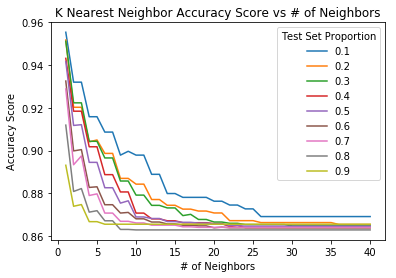

Max Accuracy: 0.955197132616
Max Test Proportion: 0.1
Max # of Neighbors: 1


In [54]:
from sklearn.neighbors import KNeighborsClassifier

params = range(1,41)
# Neighbors plot
hyperparameter_qual(KNeighborsClassifier(), 'K Nearest Neighbor', 'n_neighbors', '# of Neighbors', params, 'linear')

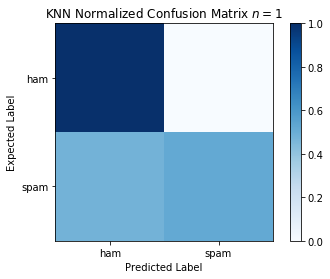

In [22]:
# Confusion matrix
plot_confuse(KNeighborsClassifier(n_neighbors=1), X_train_df, y_train, X_test_df, y_test, 'KNN', '$n = 1$')

## Naive Bayes
### Multinomial

accuracy: 0.994623655914


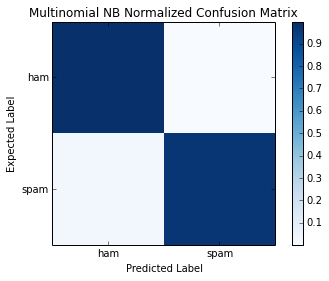

In [14]:
model = MultinomialNB()
model.fit(X_train_df,y_train)
prediction["MultinomialNB"] = model.predict(X_test_df)
print ("accuracy: "+str(accuracy_score(y_test,prediction["MultinomialNB"])))
plot_confuse(MultinomialNB(), X_train_df, y_train, X_test_df, y_test, 'Multinomial NB', '')

accuracy: 0.924731182796


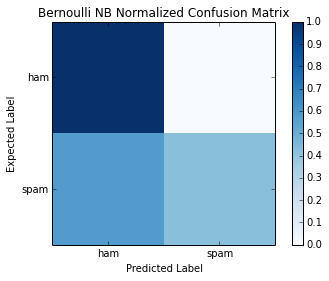

In [15]:
model = BernoulliNB()
model.fit(X_train_df,y_train)
prediction["BernoulliNB"] = model.predict(X_test_df)
print ("accuracy: "+str(accuracy_score(y_test,prediction["BernoulliNB"])))
plot_confuse(BernoulliNB(), X_train_df, y_train, X_test_df, y_test, 'Bernoulli NB', '')

It's clear from above that the multinomial Naive Bayes classifier function better than the bernoulli one. The multinomial is especially strong because text messages fit the IID (naive) assumption of the bayes model very well.

## Decision Trees

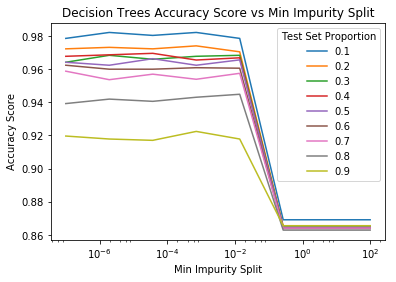

Max Accuracy: 0.982078853047
Max Test Proportion: 0.1
Max Min Impurity Split: 1.93069772888e-06


In [25]:
from sklearn import tree

dtc = tree.DecisionTreeClassifier()
params = np.logspace(-7, 2, num=8)

hyperparameter_qual(dtc, 'Decision Trees', 'min_impurity_split', 'Min Impurity Split', params, 'log')

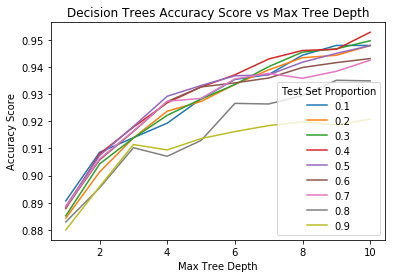

Max Accuracy: 0.952893674293
Max Test Proportion: 0.4
Max Max Tree Depth: 10


In [26]:
params = range(1,11)

hyperparameter_qual(tree.DecisionTreeClassifier(), 'Decision Trees', 'max_depth', 'Max Tree Depth', params, 'linear')

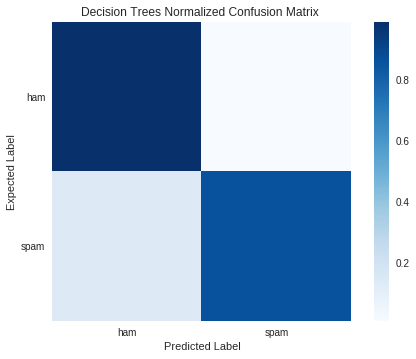

In [84]:
plot_confuse(tree.DecisionTreeClassifier(), X_train_df, y_train, X_test_df, y_test, 'Decision Trees', '')

# Logistic Regression

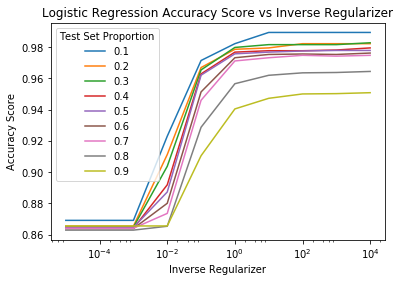

Max Accuracy: 0.989247311828
Max Test Proportion: 0.1
Max Inverse Regularizer: 10.0


In [55]:
from sklearn.linear_model import LogisticRegression

params = np.logspace(-5, 4, num=10)

hyperparameter_qual(LogisticRegression(), 'Logistic Regression', 'C', 'Inverse Regularizer', params, 'log')

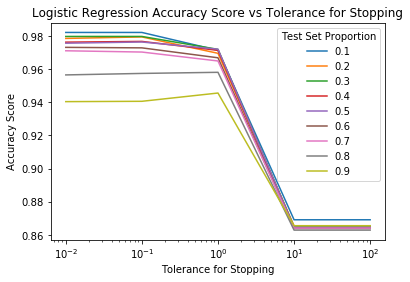

Max Accuracy: 0.982078853047
Max Test Proportion: 0.1
Max Tolerance for Stopping: 0.01


In [60]:
params = np.logspace(-2, 2, num=5)

hyperparameter_qual(LogisticRegression(), 'Logistic Regression', 'tol', 'Tolerance for Stopping', params, 'log')

In [69]:
model = LogisticRegression(C=1000, tol=0.01)
model.fit(X_train_df,y_train)
prediction["Logistic"] = model.predict(X_test_df)
accuracy_score(y_test,prediction["Logistic"])

0.98207885304659504

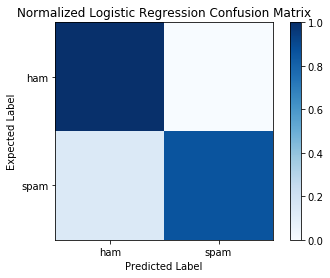

In [70]:
confmat = confusion_matrix(y_test, prediction["Logistic"])
confmat = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis]
plt.imshow(confmat, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Normalized Logistic Regression Confusion Matrix')
plt.colorbar()
plt.grid('off')
plt.ylabel('Expected Label')
plt.xlabel('Predicted Label')
tick_marks = ['ham', 'spam']
plt.xticks([0, 1], tick_marks)
plt.yticks([0, 1], tick_marks)
plt.show()

# SVM

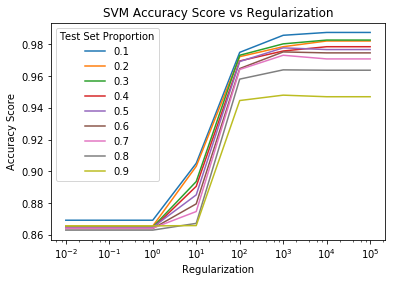

Max Accuracy: 0.987455197133
Max Test Proportion: 0.1
Max Regularization: 10000.0


In [38]:
from sklearn import svm
params = np.logspace(-2, 5, num=8)

hyperparameter_qual(svm.SVC(), 'SVM', 'C', 'Regularization', params, 'log')

In [76]:
model = svm.SVC(C=10000)
model.fit(X_train_df, y_train)
prediction['SVM'] = model.predict(X_test_df)

accuracy_score(y_test, prediction['SVM'])

0.978494623655914

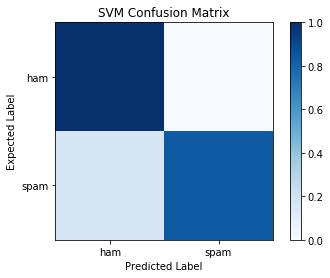

In [77]:
confmat = confusion_matrix(y_test, prediction["SVM"])
confmat = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis]
plt.imshow(confmat, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('SVM Confusion Matrix')
plt.colorbar()
plt.grid('off')
plt.ylabel('Expected Label')
plt.xlabel('Predicted Label')
tick_marks = ['ham', 'spam']
plt.xticks([0, 1], tick_marks)
plt.yticks([0, 1], tick_marks)
plt.show()

## K-fold Cross Validation
The following function adds a length feature to the model, and K folds, depending on how much we want to cross validate.

Iteration 10: 1.0
Iteration 20: 0.894736842105
Iteration 30: 1.0
Iteration 40: 0.947368421053
Iteration 50: 0.947368421053
Iteration 60: 0.894736842105
Iteration 70: 0.947368421053
Iteration 80: 0.894736842105
Iteration 90: 0.947368421053
Iteration 100: 0.894736842105
Iteration 110: 0.947368421053
Iteration 120: 0.947368421053
Iteration 130: 1.0
Iteration 140: 1.0
Iteration 150: 0.947368421053
Iteration 160: 1.0
Iteration 170: 1.0
Iteration 180: 1.0
Iteration 190: 0.944444444444
Iteration 200: 0.944444444444
Iteration 210: 0.944444444444
Iteration 220: 1.0
Iteration 230: 0.888888888889
Iteration 240: 1.0
Iteration 250: 0.944444444444
Iteration 260: 1.0
Iteration 270: 1.0
Iteration 280: 1.0
Iteration 290: 0.888888888889
Iteration 300: 0.944444444444
0.993000717875


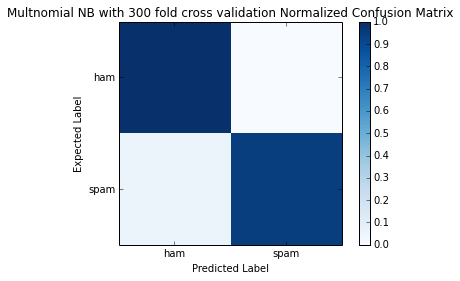

In [18]:
from sklearn.model_selection import KFold
import scipy
from scipy.sparse import csr_matrix, hstack
def crossValidate(model, prediction, modelName, messages, splits):
    vect = CountVectorizer(analyzer='word', ngram_range=(1, 3),stop_words='english') #uses 1 - 3 word length grams
    #K fold validation
    kf = KFold(n_splits=splits)

    i = 0
    #loop through cross validated input
    for train_index, test_index in kf.split(messages["text"], messages["class"]):
        i = i + 1

        X_train, X_test = messages["text"][train_index], messages["text"][test_index]
        Y_train, Y_test = messages["class"][train_index], messages["class"][test_index]
        length_train, length_test = messages["length"][train_index].as_matrix()[:,np.newaxis], messages["length"][test_index].as_matrix()[:,np.newaxis]
        length_train, length_test = scipy.sparse.coo_matrix(length_train), scipy.sparse.coo_matrix(length_test)
    
        vect.fit(X_train)
        
        #add length feature to the feature vector
        X_train_df = hstack([vect.transform(X_train), length_train])
        X_test_df = hstack([vect.transform(X_test), length_test])
        model.fit(X_train_df, Y_train)
        if (i%10 == 0):
            print( "Iteration "+str(i)+": "+str(accuracy_score(Y_test, model.predict(X_test_df))))

    #really simple to create a model and train it.
    h = scipy.sparse.coo_matrix(messages['length'].as_matrix()[:,np.newaxis])
    X_df = hstack([vect.transform(messages["text"]), h])
    prediction[modelName] = model.predict(X_df)

    #print out the accuracy score over all the messages, because we've k cross validated
    print accuracy_score(messages["class"], prediction[modelName])
    create_confuse(modelName, confusion_matrix(messages["class"], prediction[modelName]), "")
    
model = MultinomialNB()
crossValidate(model, prediction, "Multnomial NB with 300 fold cross validation", messages, 300)

Note the higher accuracy on the entire set of messages. This is because k-fold cross validation increases generalizability to the entire set.